# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a single image, and later apply the result to a video stream (really just a series of images). Watch the video clip "lane-finding-example.mp4" (also contained in this repository) to see what the output should look like. 

Let's have a look at our first image called 'solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to bring up an interactive matplotlib window displaying the image.

**Note:** you can zoom in and explore the image within the interactive matplotlib window.  If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the lines in the image, and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="laneLines_thirdPass.jpg" width="480" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output image should look like this (more or less) after line detection </p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)

This image is:  <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


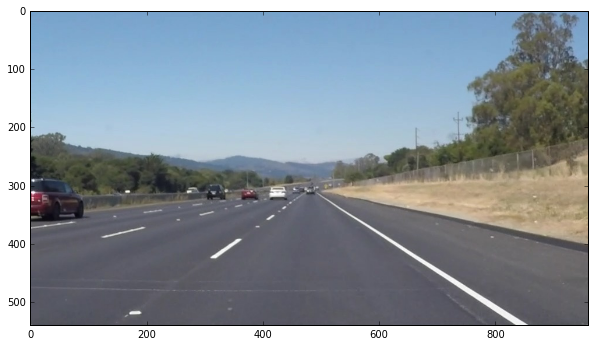

In [5]:
#reading in an image
image = mpimg.imread('solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is: ',type(image), 'with dimesions:', image.shape)
plt.imshow(image)
#the next two lines ensure that the plot window comes out on top of the browser

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

**You can run the cell below to watch the video.  Once you have a working pipeline, paste your code into the loop below and see how you did!**

### Helper functions

In [147]:
import math

def in_range(image):
    pass

def gray_scale(image):
    """Grayscale transform
    
    RBG to Grayscale image
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def region_of_interest(img, vertices):
    """
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    
    Returns mask
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,)*channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def canny(image, threshold1, threshold2, apertureSize=3, L2gradient=False):
    """Canny transform http://en.wikipedia.org/wiki/Canny_edge_detector
    
    The smallest value between threshold1 and threshold2 is used for edge linking. 
    The largest value is used to find initial segments of strong edges.
        
    apertureSize - aperture size for the Sobel operator
    
    L2gradient - whether to use L1 or L2 norm for the image gradient magnitude calculation
    
    Returns edges
    """
    return cv2.Canny(image, threshold1, threshold2, apertureSize=apertureSize, L2gradient=L2gradient)

def in_range(image, low_threshold, high_threshold):
    """
    
    """
    return cv2.inRange(image, np.array(low_threshold, dtype=np.uint8), np.array(high_threshold, dtype=np.uint8))

def hough_lines(image, rho, theta, threshold, minLineLength, maxLineGap):
    """
    rho - Distance resolution of the accumulator in pixels.
    
    theta - Angle resolution of the accumulator in radians.
    
    threshold - Accumulator threshold parameter. Only those lines are returned that get enough votes ( >𝚝𝚑𝚛𝚎𝚜𝚑𝚘𝚕𝚍 ).
    
    minLineLength - Minimum line length. Line segments shorter than that are rejected.
    
    maxLineGap - Maximum allowed gap between points on the same line to link them.
    
    Returns lines
    """
    return cv2.HoughLinesP(image, rho, theta, threshold, np.array([]), minLineLength, maxLineGap)

def gaussian_noise(image, kernel_size=5):
    return cv2.GaussianBlur(image,(kernel_size, kernel_size),0)

def draw_lines(image, lines, color=[255, 0, 0], thickness=3):
    """Draws `lines` to the `image`.
    
    Note: image should be copy so the original remains unaltered.
    """
    if lines is None:
        return
    for line in lines:
        for x1,y1,x2,y2 in line:
            dx = x2 - x1
            dy = y2 - y1
            angle = np.rad2deg(math.atan2(dy, dx))
#             if x1 < 475 and x2 > 485:
#                 continue
            # limit line angle
            if (angle > 30 and angle < 40) or (angle < -30 and angle > -40):   
                cv2.line(image,(x1,y1),(x2,y2), color, thickness)

### Try out the pipeline

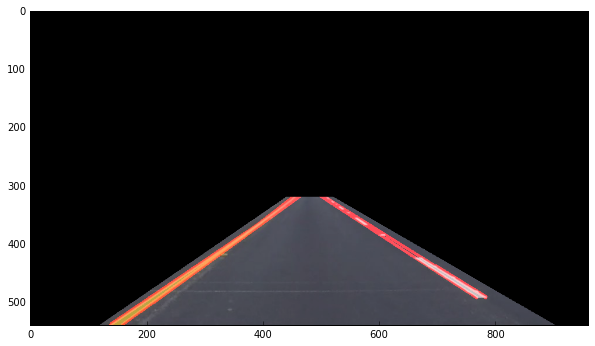

In [157]:
def pipeline(image):
    """The image lane finding pipeline
    
    Takes in the `image` and returns a new image
    with lines drawn on the lane lines.
    """
    
    # params
    kernel_size = 5
    vertices = np.array([[(120,539),(440,320), (520, 320), (900,539)]], dtype=np.int32)
    canny_low_threshold = 50
    canny_high_threshold = 150
    rho = 1
    theta = np.radians(1)
    hough_threshold = 50
    min_line_length = 10
    max_line_gap = 100
    
    blank = np.copy(image) * 0
    
    gray_img = gray_scale(image)
    noise = gaussian_noise(gray_img, kernel_size)
#     edges = in_range(noise, 128, 255)
    edges = canny(noise, canny_low_threshold, canny_high_threshold)
    lines = hough_lines(edges, rho, theta, hough_threshold, min_line_length, max_line_gap)
    draw_lines(blank, lines)
    combo = cv2.addWeighted(image, 0.8, blank, 1, 0)
#     combo = cv2.addWeighted(np.dstack((edges, edges, edges)), 0.8, blank, 1, 0) 
    combo = region_of_interest(combo, vertices)
    # and and xor op here to show full
    return combo

# image = mpimg.imread('solidWhiteRight.jpg')
image = mpimg.imread('solidYellowLeft.jpg')
out_img = pipeline(image)
plt.imshow(out_img, cmap='Greys_r')

In [158]:
#Run this cell without changing anything first to watch the video
cv2.startWindowThread()
cv2.namedWindow('Lane-Finding')
cap = cv2.VideoCapture('solidWhiteRight.mp4')

while cap.isOpened():

    ret, image = cap.read()
    if image is not None:
        result = pipeline(image) # and get rid of this line
        cv2.imshow('Lane-Finding',result)
    else:
        break
        
    k = cv2.waitKey(30) & 0xff
    if k == 27 :
        break

cap.release()
cv2.destroyAllWindows()

**Now try it again with a new video...  does your algorithm still work?  Or do you need to modify it?**

---

<figure>
 <img src="solidYellowLeft.jpg" width="480" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Now the scenario looks like this! </p> 
 </figcaption>
</figure>

---

In [ ]:
#run this cell to look at the above image in an interactive window
image = mpimg.imread('solidYellowLeft.jpg')
print('This image is: ',type(image), 'with dimesions:', image.shape)
plt.imshow(image)
fig = plt.gcf()
fig.canvas.manager.window.raise_()

In [159]:
cv2.startWindowThread()
cv2.namedWindow('Lane-Finding')
cap = cv2.VideoCapture('solidYellowLeft.mp4')

while cap.isOpened():

    ret, image = cap.read()
    if image is not None:
        result = pipeline(image) # and get rid of this line
        cv2.imshow('Lane-Finding', result)
    else:
        break
        
    k = cv2.waitKey(30) & 0xff
    if k == 27 :
        break

cap.release()
cv2.destroyAllWindows()